#LSTM autoencoder for anomaly detection


In [73]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout, RepeatVector, TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime

In [74]:
 from google.colab import files
 uploaded = files.upload ()

Saving GE (2).csv to GE (2).csv


In [76]:
df = pd.read_csv('GE (2).csv')

Start date is:  1962-01-02 00:00:00
End date is:  2021-07-16 00:00:00


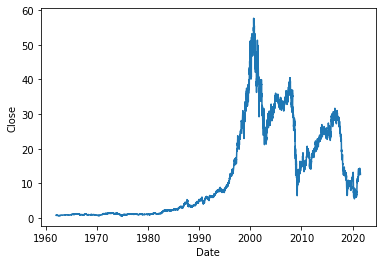

In [77]:
df = df[['Date', 'Close']] #selecting the date and close columns
df['Date'] = pd.to_datetime(df['Date']) # date is in object form and not date time format

sns.lineplot(x=df['Date'], y=df['Close'])

print('Start date is: ', df['Date'].min())
print('End date is: ', df['Date'].max())


In [78]:
train, test = df.loc[df['Date'] <= '2003-12-31'], df.loc[df['Date'] > '2003-12-31']

In [79]:
train

,Date,Close
0,1962-01-02,0.748698
1,1962-01-03,0.741186
2,1962-01-04,0.732422
3,1962-01-05,0.713642
4,1962-01-08,0.712390
...,...,...
10568,2003-12-24,29.711538
10569,2003-12-26,29.538462
10570,2003-12-29,29.644232
10571,2003-12-30,29.538462


In [80]:
#Normalizing dataset for use by LSTM

scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])


In [81]:
train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [82]:
seq_size = 30  # break down the time series data into sequence size of 30, ie 30 datapoints will be used for 1 prediction

In [83]:
def to_sequences(x,y, seq_size=1): #takes 30 values for x and the 31st value, the value to be predicted, as y
  x_values = []
  y_values = []

  for i in range(len(x)-seq_size):
    x_values.append(x.iloc[i:(i+seq_size)].values)   #picks the 30th value
    y_values.append(y.iloc[i+seq_size])      #picks the 31st value, as it has not been constructed as a range which in python means the number beofre it is picked

  return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequences(train[['Close']], train['Close'], seq_size)
testX,testY = to_sequences(test[['Close']], test['Close'], seq_size)



In [84]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)) #as evident in the model summary it will return a sewuence of 30 values having 128 features ot the next layer
model.add(LSTM(64, activation='relu', return_sequences=False)) #return sequences is false meaning it will only return an output of 1x64 as opposed to previous layer which returns 30x128
model.add(RepeatVector(trainX.shape[1])) # repeats the vector 30 times as the next layer requires an input of 30x64
model.add(LSTM(64, activation='relu', return_sequences=True)) 
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(trainX.shape[2]))) # creates a vector of the length of previous layers features, so bascially 128 by one and it multiplies that with the output vector of previous layer which is 30x128 creating a vector of 30x1 which is the size of the input vector for the e3ncoder. after entering the new data for decoding, review the reconstruction loss, if high then its an anomaly. further details in first 5 mins of video.
model.compile(optimizer='adam', loss='mae')
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 30, 128)           66560     
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 30, 64)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
lstm_17 (LSTM)               (None, 30, 128)           98816     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 1)             129       
Total params: 247,937
Trainable params: 247,937
Non-trainable params: 0
________________________________________________

Epoch 1/10
297/297 [==============================] - 35s 97ms/step - loss: 0.1626 - val_loss: 0.3728
Epoch 2/10
297/297 [==============================] - 27s 90ms/step - loss: 0.0281 - val_loss: 0.2511
Epoch 3/10
297/297 [==============================] - 27s 91ms/step - loss: 0.0180 - val_loss: 0.2696
Epoch 4/10
297/297 [==============================] - 27s 91ms/step - loss: 0.0164 - val_loss: 0.2260
Epoch 5/10
297/297 [==============================] - 27s 90ms/step - loss: 0.0171 - val_loss: 0.3036
Epoch 6/10
297/297 [==============================] - 27s 90ms/step - loss: 0.0167 - val_loss: 0.1320
Epoch 7/10
297/297 [==============================] - 27s 90ms/step - loss: 0.0125 - val_loss: 0.2956
Epoch 8/10
297/297 [==============================] - 27s 91ms/step - loss: 0.0177 - val_loss: 0.1218
Epoch 9/10
297/297 [==============================] - 27s 91ms/step - loss: 0.0135 - val_loss: 0.1989
Epoch 10/10
297/297 [==============================] - 27s 91ms/step - loss: 0.012

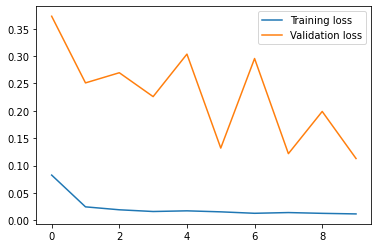

In [85]:
history = model.fit(trainX,trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()



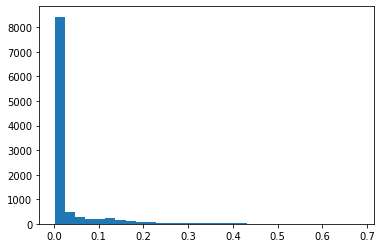

In [96]:
#Point beyond which training error is large is called an anomaly.
#checking the mean absolute error of the predicted data
trainPredict= model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict-trainX), axis=1)
plt.hist(trainMAE, bins = 30)
max_trainMAE = 0.3 #defines the threshold value of the MAE which we are comfortable our models predictions having without being labelled as an anomaly. selection of this value was based on the fact that most values of training dataset are within this range


(array([358., 863., 815., 558., 422., 323., 258., 203., 151.,  85.,  78.,
         44.,  36.,  39.,  39.,  28.,  28.,  12.,  10.,   8.,   9.,   6.,
          3.,   1.,   1.,   3.,   0.,   2.,   1.,   1.]),
 array([0.01044344, 0.02327741, 0.03611138, 0.04894536, 0.06177933,
        0.07461331, 0.08744728, 0.10028126, 0.11311523, 0.12594921,
        0.13878318, 0.15161716, 0.16445113, 0.17728511, 0.19011908,
        0.20295306, 0.21578703, 0.22862101, 0.24145498, 0.25428896,
        0.26712293, 0.2799569 , 0.29279088, 0.30562485, 0.31845883,
        0.3312928 , 0.34412678, 0.35696075, 0.36979473, 0.3826287 ,
        0.39546268]),
 <a list of 30 Patch objects>)

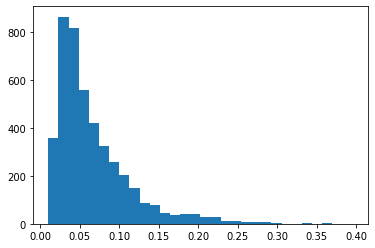

In [97]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)



As some of the values in the test dataset are beyond 0.8 they can be considered anomalous 

In [98]:
test[seq_size:]

,Date,Close
10603,2004-02-17,1.932164
10604,2004-02-18,1.908838
10605,2004-02-19,1.897175
10606,2004-02-20,1.904951
10607,2004-02-23,1.960932
...,...,...
14983,2021-07-12,0.422567
14984,2021-07-13,0.404777
14985,2021-07-14,0.398308
14986,2021-07-15,0.394265


In [99]:
#setting up a dataframe for easy plotting of values 
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE'] # column containing boolean value describing the level of testMAE relative to maxMAE
anomaly_df['Close'] = test[seq_size:]['Close']



In [100]:
anomaly_df

,Date,Close,testMAE,max_trainMAE,anomaly
10603,2004-02-17,1.932164,0.059187,0.3,False
10604,2004-02-18,1.908838,0.055091,0.3,False
10605,2004-02-19,1.897175,0.053376,0.3,False
10606,2004-02-20,1.904951,0.053103,0.3,False
10607,2004-02-23,1.960932,0.054037,0.3,False
...,...,...,...,...,...
14983,2021-07-12,0.422567,0.038938,0.3,False
14984,2021-07-13,0.404777,0.036025,0.3,False
14985,2021-07-14,0.398308,0.035093,0.3,False
14986,2021-07-15,0.394265,0.034877,0.3,False


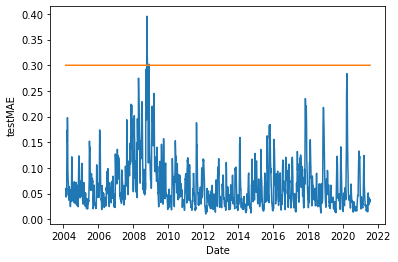

In [101]:
#plot test MAE vs max_trainMAE
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'])







The anomaly in 2008 is obviously reflecting the widespread economic collapse that year.

The anomaly reflected in 2008 is 

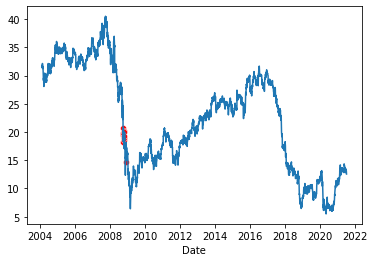

In [102]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

#Plot anomalies
sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['Close']))
sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), color='r')